In [11]:
import math

from tqdm import tqdm
from itertools import product
from joblib import Parallel, delayed

import numpy as np

from matplotlib import pyplot as plt
from IPython.display import HTML

from matk.utils.animation import animate_frames
from matk.models.tree_burn import TreeBurnModel, F, T, B, L, ST

%matplotlib inline

In [2]:
BIG_STEPS = 1_000_000

## Base model

In [3]:
tree_burn_model = TreeBurnModel(
    field_size=(512,512), 
    forest_density=0.75, 
    activate_wind=True, 
    vertical_wind=-20, horizontal_wind=0,
    n_lakes=3,
    lake_area=100,
    n_grasses=2,
    grass_area=100,
    slow_tree_density=0.2,
    slow_tree_burn_prob=0.5
)

In [4]:
tree_burn_model.run_n_steps(BIG_STEPS)

  0%|          | 734/1000000 [00:07<2:50:58, 97.41it/s] 


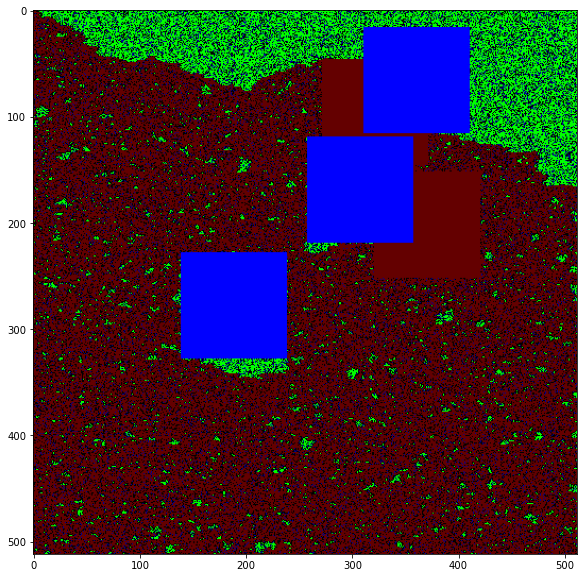

In [94]:
plt.figure(figsize=(10,10))
plt.imshow(tree_burn_model[-1])

# Experiments with base (no wind lakes no slow trees no grass)

In [6]:
def make_exp_base(model_config):
    density_space = np.linspace(0.001, 1, num=10)
    survive_space = []

    for density in tqdm(density_space):
        model_config['forest_density'] = density
        temp_model = TreeBurnModel(**model_config)
        temp_model.run_n_steps(BIG_STEPS, verbose=False)
        survive_percent = temp_model.action_history[-1][:,:,T].sum() / temp_model.action_history[0][:,:,T].sum()
        survive_space.append(survive_percent)

    survive_space = np.array(survive_space)
    return density_space, survive_space

In [7]:
exp_x, exp_y = make_exp_base(dict(
    field_size=(256,256), 
    activate_wind=False, 
    n_lakes=0,
))

100%|██████████| 10/10 [00:03<00:00,  2.86it/s]


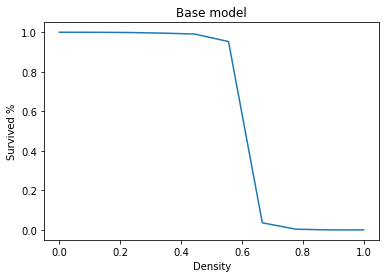

In [8]:
plt.title('Base model')
plt.plot(exp_x, exp_y)
plt.xlabel('Density')
plt.ylabel('Survived %')
plt.show()

# Var 1

# Experiments with slow trees (no wind) 

In [9]:
def make_exp_slow_tree(model_config, use_parallel = True):
    # 30 20 10 
    density_space = np.linspace(0.001, 1, num=20)
    slow_tree_dencity_space = np.linspace(0.001, 1, num=10)
    slow_tree_burn_prob_space = np.linspace(0.001, 1, num=10)
    
    if use_parallel:
        def make_one_exp(den_t, s_den_t, s_prob_t):
            model_config['forest_density'] = den_t
            model_config['slow_tree_density'] = s_den_t
            model_config['slow_tree_burn_prob'] = s_prob_t

            temp_model = TreeBurnModel(**model_config)
            temp_model.run_n_steps(BIG_STEPS, verbose=False)

            survive_s = np.array([
                temp_model.action_history[0][:,:,ST].sum(), 
                temp_model.action_history[-1][:,:,ST].sum()
            ])
            survive_c = np.array([
                temp_model.action_history[0][:,:,T].sum(), 
                temp_model.action_history[-1][:,:,T].sum()
            ])

            return survive_s, survive_c, den_t, s_den_t, s_prob_t
        
        temp_r = Parallel(n_jobs=12)(delayed(make_one_exp)(den, s_den, s_prob) for den, s_den, s_prob in product(
            density_space,
            slow_tree_dencity_space,
            slow_tree_burn_prob_space,
        ))
        
        return (
            np.stack([el[0] for el in temp_r]),
            np.stack([el[1] for el in temp_r]),
            np.array([el[2] for el in temp_r]),
            np.array([el[3] for el in temp_r]),
            np.array([el[4] for el in temp_r])
        )
        
    else:
        
        survive_space_casual = []
        survive_space_slow = []
        new_density_space = []
        new_slow_tree_dencity_space = []
        new_slow_tree_burn_prob_space = []

        for den, s_den, s_prob in tqdm(product(
            density_space,
            slow_tree_dencity_space,
            slow_tree_burn_prob_space,
        ), total=10*10*10):
            model_config['forest_density'] = den
            model_config['slow_tree_density'] = s_den
            model_config['slow_tree_burn_prob'] = s_prob

            temp_model = TreeBurnModel(**model_config)
            temp_model.run_n_steps(BIG_STEPS, verbose=False)

            survive_s = np.array([temp_model.action_history[0][:,:,ST].sum(), temp_model.action_history[-1][:,:,ST].sum()])
            survive_c = np.array([temp_model.action_history[0][:,:,T].sum(), temp_model.action_history[-1][:,:,T].sum()])

            survive_space_casual.append(survive_c)
            survive_space_slow.append(survive_s)
            new_density_space.append(den)
            new_slow_tree_dencity_space.append(s_den)
            new_slow_tree_burn_prob_space.append(s_prob)

        return (
            np.stack(survive_space_casual), 
            np.stack(survive_space_slow), 
            np.array(new_density_space),
            np.array(new_slow_tree_dencity_space),
            np.array(new_slow_tree_burn_prob_space)
        )

In [12]:
exp_slow_tree_result = make_exp_slow_tree(dict(
    field_size=(256,256), 
    activate_wind=False, 
    n_lakes=0,
))

/home/vsydorskyi/anaconda3/envs/venv/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


In [92]:
parsed_result_exp_slow_tree = dict(
    survive_space_slow=exp_slow_tree_result[0],
    survive_space_casual=exp_slow_tree_result[1],
    density_space=exp_slow_tree_result[2],
    slow_tree_dencity_space=exp_slow_tree_result[3],
    slow_tree_burn_prob_space=exp_slow_tree_result[4]
)

In [54]:
np.savez(
    'result_exp_slow_tree.npz',
    parsed_result_exp_slow_tree
)

# Experiments with grass and wind

In [24]:
def make_exp_grass(model_config, use_parallel = True):
    # 30 10 10 10 
    density_space = np.linspace(0.001, 1, num=10)
    grass_area_space = list(range(10, 100, 10))
    wind_space = np.linspace(-24, 24, num=10)
    n_monte_carlo = 5
    
    if use_parallel:
        def make_one_exp(den_t, w_s_t, g_a_t):
            reached = 0
            for _ in range(n_monte_carlo):
                model_config['forest_density'] = den_t
                model_config['vertical_wind'] = w_s_t
                model_config['grass_area'] = g_a_t

                temp_model = TreeBurnModel(**model_config)
                temp_model.run_n_steps(BIG_STEPS, verbose=False)

                reached += int(np.any(temp_model.action_history[-1][:,-1,B]))

            reached = reached / n_monte_carlo

            return reached, den_t, w_s_t, g_a_t
        
        temp_r = Parallel(n_jobs=12)(delayed(make_one_exp)(den, w_s, g_a) for den, g_a, w_s in product(
            density_space,
            grass_area_space,
            wind_space,
        ))
        
        return (
            np.array([el[0] for el in temp_r]),
            np.array([el[1] for el in temp_r]),
            np.array([el[2] for el in temp_r]),
            np.array([el[3] for el in temp_r])
        )
    
    else:
    
        fire_through_space = []
        new_density_space = []
        new_grass_area_space = []
        new_wind_space = []

        for den, g_a, w_s in tqdm(product(
            density_space,
            grass_area_space,
            wind_space,
        ), total=30*10*10):
            reached = 0
            for _ in range(n_monte_carlo):
                model_config['forest_density'] = den
                model_config['vertical_wind'] = w_s
                model_config['grass_area'] = g_a

                temp_model = TreeBurnModel(**model_config)
                temp_model.run_n_steps(BIG_STEPS, verbose=False)

                reached += int(np.any(temp_model.action_history[-1][:,-1,B]))

            fire_through_space.append(reached / n_monte_carlo)
            new_density_space.append(den)
            new_grass_area_space.append(g_a)
            new_wind_space.append(w_s)

        return (
            np.array(fire_through_space),
            np.array(new_density_space),
            np.array(new_grass_area_space),
            np.array(new_wind_space)
        )

In [25]:
exp_grass_wind_result = make_exp_grass(dict(
    field_size=(256,256), 
    activate_wind=True, 
    n_grasses=3,
))

In [91]:
parsed_grass_wind_result = dict(
    fire_through_space=exp_grass_wind_result[0],
    density_space=exp_grass_wind_result[1],
    grass_area_space=exp_grass_wind_result[3],
    wind_space=exp_grass_wind_result[2],
)

In [68]:
np.savez(
    'exp_grass_wind.npz',
    parsed_grass_wind_result
)

# Visualise 

## First experiment

In [55]:
survived_casul_percent = np.array([
    el[1] / el[0] if el[0] != 0 else 0
    for el in parsed_result_exp_slow_tree['survive_space_casual']])

survived_slow_percent = np.array([
    el[1] / el[0] if el[0] != 0 else 0
    for el in parsed_result_exp_slow_tree['survive_space_slow']])

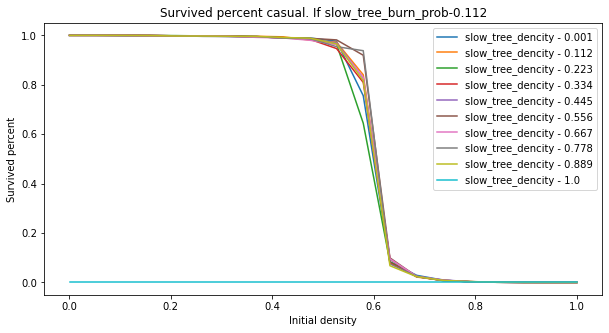

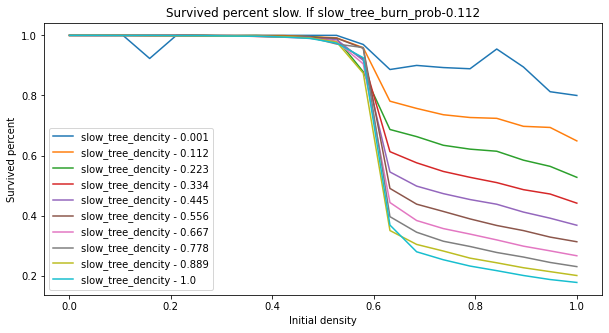

In [97]:
slow_tree_dencity = 0.556
slow_tree_burn_prob = 0.112

mask_2 = parsed_result_exp_slow_tree['slow_tree_burn_prob_space'] == slow_tree_burn_prob
 
plt.figure(figsize=(10,5))
plt.title(f'Survived percent casual. If slow_tree_burn_prob-{slow_tree_burn_prob}')
for slow_tree_dencity in np.unique(parsed_result_exp_slow_tree['slow_tree_dencity_space']):
    mask_1 = parsed_result_exp_slow_tree['slow_tree_dencity_space'] == slow_tree_dencity
    plt.plot(
        parsed_result_exp_slow_tree['density_space'][mask_1 & mask_2], 
        survived_casul_percent[mask_1 & mask_2],
        label=f'slow_tree_dencity - {slow_tree_dencity}'
    )
plt.ylabel('Survived percent')
plt.xlabel('Initial density')
plt.legend()
plt.show()

plt.figure(figsize=(10,5))
plt.title(f'Survived percent slow. If slow_tree_burn_prob-{slow_tree_burn_prob}')
for slow_tree_dencity in np.unique(parsed_result_exp_slow_tree['slow_tree_dencity_space']):
    mask_1 = parsed_result_exp_slow_tree['slow_tree_dencity_space'] == slow_tree_dencity
    plt.plot(
        parsed_result_exp_slow_tree['density_space'][mask_1 & mask_2], 
        survived_slow_percent[mask_1 & mask_2],
        label=f'slow_tree_dencity - {slow_tree_dencity}'
    )
plt.ylabel('Survived percent')
plt.xlabel('Initial density')
plt.legend()
plt.show()

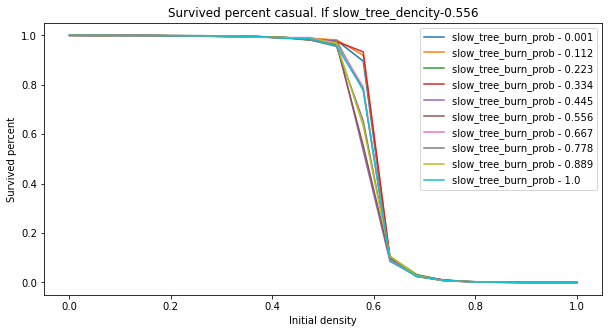

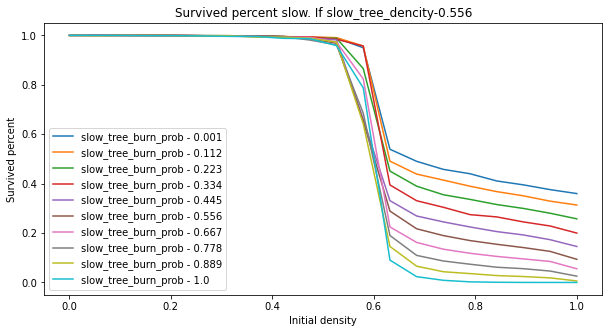

In [101]:
slow_tree_dencity = 0.556
slow_tree_burn_prob = 0.112

mask_1 = parsed_result_exp_slow_tree['slow_tree_dencity_space'] == slow_tree_dencity
 
plt.figure(figsize=(10,5))
plt.title(f'Survived percent casual. If slow_tree_dencity-{slow_tree_dencity}')
for slow_tree_burn_prob in np.unique(parsed_result_exp_slow_tree['slow_tree_burn_prob_space']):
    mask_2 = parsed_result_exp_slow_tree['slow_tree_burn_prob_space'] == slow_tree_burn_prob
    plt.plot(
        parsed_result_exp_slow_tree['density_space'][mask_1 & mask_2], 
        survived_casul_percent[mask_1 & mask_2],
        label=f'slow_tree_burn_prob - {slow_tree_burn_prob}'
    )
plt.ylabel('Survived percent')
plt.xlabel('Initial density')
plt.legend()
plt.show()

plt.figure(figsize=(10,5))
plt.title(f'Survived percent slow. If slow_tree_dencity-{slow_tree_dencity}')
for slow_tree_burn_prob in np.unique(parsed_result_exp_slow_tree['slow_tree_burn_prob_space']):
    mask_2 = parsed_result_exp_slow_tree['slow_tree_burn_prob_space'] == slow_tree_burn_prob
    plt.plot(
        parsed_result_exp_slow_tree['density_space'][mask_1 & mask_2], 
        survived_slow_percent[mask_1 & mask_2],
        label=f'slow_tree_burn_prob - {slow_tree_burn_prob}'
    )
plt.ylabel('Survived percent')
plt.xlabel('Initial density')
plt.legend()
plt.show()

## Second experiment

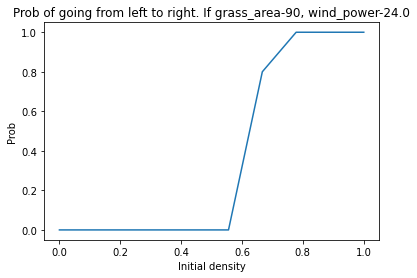

In [90]:
grass_area = 90
wind_power = np.unique(parsed_grass_wind_result['wind_space'])[9]

mask_1 = parsed_grass_wind_result['grass_area_space'] == grass_area
mask_2 = parsed_grass_wind_result['wind_space'] == wind_power

plt.title(f'Prob of going from left to right. If grass_area-{grass_area}, wind_power-{wind_power}')
plt.plot(
    parsed_grass_wind_result['density_space'][mask_1 & mask_2], 
    parsed_grass_wind_result['fire_through_space'][mask_1 & mask_2]
)
plt.ylabel('Prob')
plt.xlabel('Initial density')
plt.show()

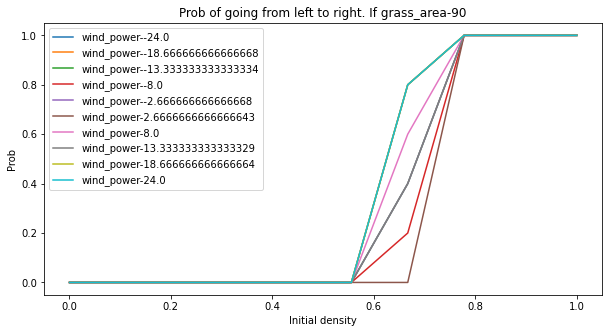

In [102]:
grass_area = 90

mask_1 = parsed_grass_wind_result['grass_area_space'] == grass_area

plt.figure(figsize=(10,5))
plt.title(f'Prob of going from left to right. If grass_area-{grass_area}')
for wind_power in np.unique(parsed_grass_wind_result['wind_space']):
    mask_2 = parsed_grass_wind_result['wind_space'] == wind_power
    plt.plot(
        parsed_grass_wind_result['density_space'][mask_1 & mask_2], 
        parsed_grass_wind_result['fire_through_space'][mask_1 & mask_2],
        label=f'wind_power-{wind_power}'
    )
plt.ylabel('Prob')
plt.xlabel('Initial density')
plt.legend()
plt.show()

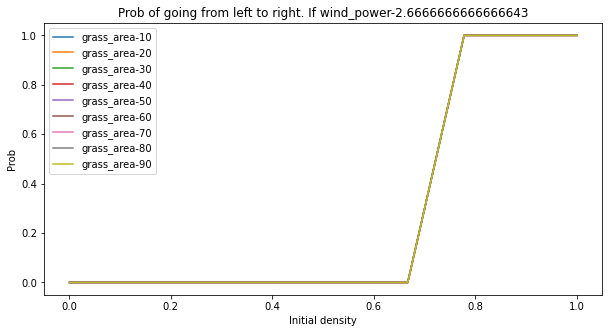

In [103]:
wind_power = np.unique(parsed_grass_wind_result['wind_space'])[5]

mask_1 = parsed_grass_wind_result['wind_space'] == wind_power

plt.figure(figsize=(10,5))
plt.title(f'Prob of going from left to right. If wind_power-{wind_power}')
for grass_area in np.unique(parsed_grass_wind_result['grass_area_space']):
    mask_2 = parsed_grass_wind_result['grass_area_space'] == grass_area
    plt.plot(
        parsed_grass_wind_result['density_space'][mask_1 & mask_2], 
        parsed_grass_wind_result['fire_through_space'][mask_1 & mask_2],
        label=f'grass_area-{grass_area}'
    )
plt.ylabel('Prob')
plt.xlabel('Initial density')
plt.legend()
plt.show()